In [1]:
from PokUtils import (build_pokemon_dataset, show_batch, save_samples,
                      save_model, denorm)

from PokNet import Discriminator128, Generator128, get_noised_labels 

import torch
import torch.nn as nn
import random
import numpy as np

import shutil
from IPython.display import clear_output
from tqdm.notebook import tqdm
import time
import os


random.seed(69)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [20]:
import json
data = {"username":"trynottofly","key":"92f4117832fd8c85f41e37024984cd0f"}
with open('kaggle.json', 'w') as f:
    json.dump(data, f)

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download hlrhegemony/pokemon-image-dataset

! unzip "pokemon-image-dataset.zip"

mkdir: cannot create directory ‘/home/msst/.kaggle’: File exists
100%|██████████████████████████████████████| 57.9M/57.9M [00:12<00:00, 5.35MB/s]
100%|██████████████████████████████████████| 57.9M/57.9M [00:12<00:00, 4.68MB/s]
Archive:  pokemon-image-dataset.zip
  inflating: images/Abomasnow/0.jpg  
  inflating: images/Abomasnow/1.jpg  
  inflating: images/Abomasnow/2.jpg  
  inflating: images/Abomasnow/3.jpg  
  inflating: images/Abra/0.jpg       
  inflating: images/Abra/1.jpg       
  inflating: images/Abra/2.jpg       
  inflating: images/Abra/3.jpg       
  inflating: images/Absol/0.jpg      
  inflating: images/Absol/1.jpg      
  inflating: images/Absol/2.jpg      
  inflating: images/Absol/3.jpg      
  inflating: images/Accelgor/0.jpg   
  inflating: images/Accelgor/1.jpg   
  inflating: images/Aegislash/0.jpg  
  inflating: images/Aegislash/1.jpg  
  inflating: images/Aegislash/2.jpg  
  inflating: images/Aegislash/3.jpg  
  inflating: images/Aerodactyl/0.jpg  
  inflating: i

In [2]:
pokemons = build_pokemon_dataset(data_dirs=["images"], img_size=64,
                                 aug_size=3, to_gray=False,
                                 edges=None, with_sharpness=5,
                                 memSTOP = 3)

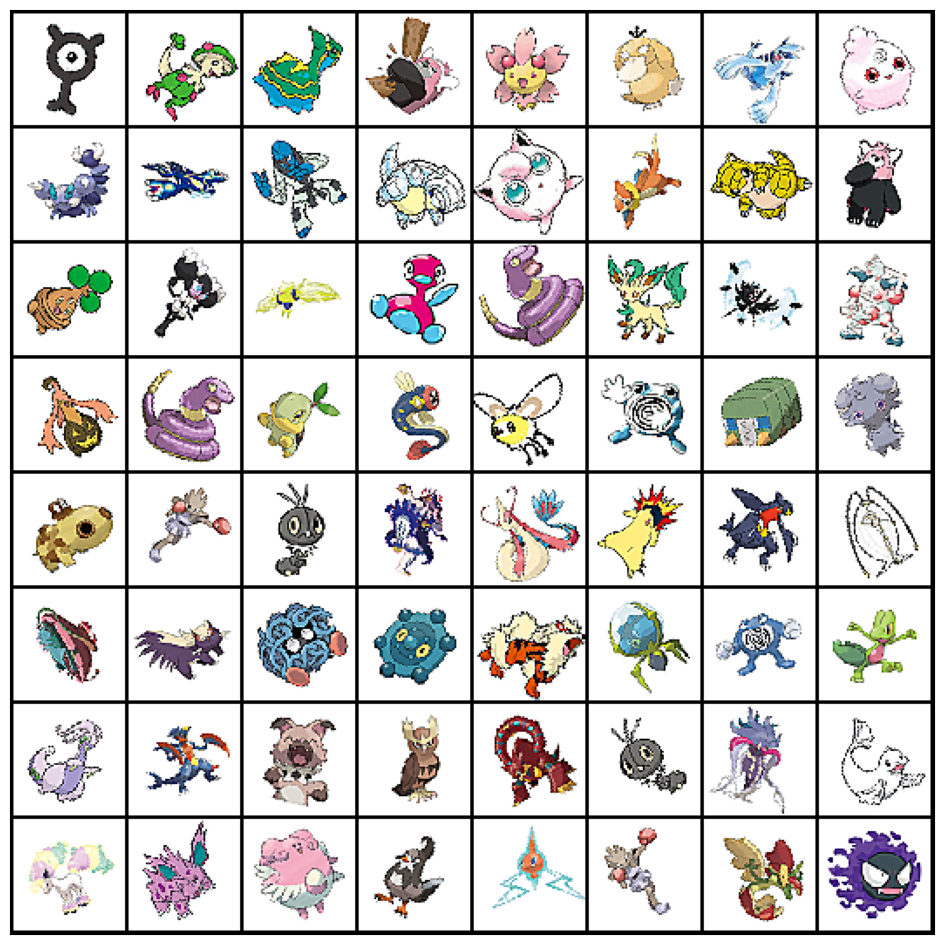

In [3]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(pokemons, batch_size=batch_size, shuffle=True)
show_batch(train_loader)

In [4]:
class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim,activation):
        super(Self_Attn,self).__init__()
        self.chanel_in = in_dim
        self.activation = activation
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out,attention

class Generator(nn.Module):
    """Generator."""

    def __init__(self, batch_size, image_size=64, z_dim=100, conv_dim=64):
        super(Generator, self).__init__()
        self.imsize = image_size
        layer1 = []
        layer2 = []
        layer3 = []
        last = []

        repeat_num = int(np.log2(self.imsize)) - 3
        mult = 2 ** repeat_num # 8
        layer1.append(SpectralNorm(nn.ConvTranspose2d(z_dim, conv_dim * mult, 4)))
        layer1.append(nn.BatchNorm2d(conv_dim * mult))
        layer1.append(nn.ReLU())

        curr_dim = conv_dim * mult

        layer2.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer2.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer2.append(nn.ReLU())

        curr_dim = int(curr_dim / 2)

        layer3.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer3.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer3.append(nn.ReLU())

        if self.imsize == 64:
            layer4 = []
            curr_dim = int(curr_dim / 2)
            layer4.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
            layer4.append(nn.BatchNorm2d(int(curr_dim / 2)))
            layer4.append(nn.ReLU())
            self.l4 = nn.Sequential(*layer4)
            curr_dim = int(curr_dim / 2)

        self.l1 = nn.Sequential(*layer1)
        self.l2 = nn.Sequential(*layer2)
        self.l3 = nn.Sequential(*layer3)

        last.append(nn.ConvTranspose2d(curr_dim, 3, 4, 2, 1))
        last.append(nn.Tanh())
        self.last = nn.Sequential(*last)

        self.attn1 = Self_Attn( 128, 'relu')
        self.attn2 = Self_Attn( 64,  'relu')

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        out=self.l1(z)
        out=self.l2(out)
        out=self.l3(out)
        out,p1 = self.attn1(out)
        out=self.l4(out)
        out,p2 = self.attn2(out)
        out=self.last(out)

        return out, p1, p2


class Discriminator(nn.Module):
    """Discriminator, Auxiliary Classifier."""

    def __init__(self, batch_size=64, image_size=64, conv_dim=64):
        super(Discriminator, self).__init__()
        self.imsize = image_size
        layer1 = []
        layer2 = []
        layer3 = []
        last = []

        layer1.append(SpectralNorm(nn.Conv2d(3, conv_dim, 4, 2, 1)))
        layer1.append(nn.LeakyReLU(0.1))

        curr_dim = conv_dim

        layer2.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer2.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2

        layer3.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer3.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2

        if self.imsize == 64:
            layer4 = []
            layer4.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
            layer4.append(nn.LeakyReLU(0.1))
            self.l4 = nn.Sequential(*layer4)
            curr_dim = curr_dim*2
        self.l1 = nn.Sequential(*layer1)
        self.l2 = nn.Sequential(*layer2)
        self.l3 = nn.Sequential(*layer3)

        last.append(nn.Conv2d(curr_dim, 1, 4))
        self.last = nn.Sequential(*last)

        self.attn1 = Self_Attn(256, 'relu')
        self.attn2 = Self_Attn(512, 'relu')

    def forward(self, x):
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        out,p1 = self.attn1(out)
        out=self.l4(out)
        out,p2 = self.attn2(out)
        out=self.last(out)

        return out.squeeze(), p1, p2

In [5]:
class Trainer(object):
    def __init__(self, data_loader, config):

        # Data loader
        self.data_loader = data_loader

        # exact model and loss
        self.model = config.model
        self.adv_loss = config.adv_loss

        # Model hyper-parameters
        self.imsize = config.imsize
        self.g_num = config.g_num
        self.z_dim = config.z_dim
        self.g_conv_dim = config.g_conv_dim
        self.d_conv_dim = config.d_conv_dim
        self.parallel = config.parallel

        self.lambda_gp = config.lambda_gp
        self.total_step = config.total_step
        self.d_iters = config.d_iters
        self.batch_size = config.batch_size
        self.num_workers = config.num_workers
        self.g_lr = config.g_lr
        self.d_lr = config.d_lr
        self.lr_decay = config.lr_decay
        self.beta1 = config.beta1
        self.beta2 = config.beta2
        self.pretrained_model = config.pretrained_model

        self.dataset = config.dataset
        self.use_tensorboard = config.use_tensorboard
        self.image_path = config.image_path
        self.log_path = config.log_path
        self.model_save_path = config.model_save_path
        self.sample_path = config.sample_path
        self.log_step = config.log_step
        self.sample_step = config.sample_step
        self.model_save_step = config.model_save_step
        self.version = config.version

        # Path
        self.log_path = os.path.join(config.log_path, self.version)
        self.sample_path = os.path.join(config.sample_path, self.version)
        self.model_save_path = os.path.join(config.model_save_path, self.version)

        self.build_model()

        if self.use_tensorboard:
            self.build_tensorboard()

        # Start with trained model
        if self.pretrained_model:
            self.load_pretrained_model()



    def train(self):

        # Data iterator
        data_iter = iter(self.data_loader)
        step_per_epoch = len(self.data_loader)
        model_save_step = int(self.model_save_step * step_per_epoch)

        # Fixed input for debugging
        fixed_z = tensor2var(torch.randn(self.batch_size, self.z_dim))

        # Start with trained model
        if self.pretrained_model:
            start = self.pretrained_model + 1
        else:
            start = 0

        # Start time
        start_time = time.time()
        for step in range(start, self.total_step):

            # ================== Train D ================== #
            self.D.train()
            self.G.train()

            try:
                real_images, _ = next(data_iter)
            except:
                data_iter = iter(self.data_loader)
                real_images, _ = next(data_iter)

            # Compute loss with real images
            # dr1, dr2, df1, df2, gf1, gf2 are attention scores
            real_images = tensor2var(real_images)
            d_out_real,dr1,dr2 = self.D(real_images)
            if self.adv_loss == 'wgan-gp':
                d_loss_real = - torch.mean(d_out_real)
            elif self.adv_loss == 'hinge':
                d_loss_real = torch.nn.ReLU()(1.0 - d_out_real).mean()

            # apply Gumbel Softmax
            z = tensor2var(torch.randn(real_images.size(0), self.z_dim))
            fake_images,gf1,gf2 = self.G(z)
            d_out_fake,df1,df2 = self.D(fake_images)

            if self.adv_loss == 'wgan-gp':
                d_loss_fake = d_out_fake.mean()
            elif self.adv_loss == 'hinge':
                d_loss_fake = torch.nn.ReLU()(1.0 + d_out_fake).mean()


            # Backward + Optimize
            d_loss = d_loss_real + d_loss_fake
            self.reset_grad()
            d_loss.backward()
            self.d_optimizer.step()


            if self.adv_loss == 'wgan-gp':
                # Compute gradient penalty
                alpha = torch.rand(real_images.size(0), 1, 1, 1).cuda().expand_as(real_images)
                interpolated = Variable(alpha * real_images.data + (1 - alpha) * fake_images.data, requires_grad=True)
                out,_,_ = self.D(interpolated)

                grad = torch.autograd.grad(outputs=out,
                                           inputs=interpolated,
                                           grad_outputs=torch.ones(out.size()).cuda(),
                                           retain_graph=True,
                                           create_graph=True,
                                           only_inputs=True)[0]

                grad = grad.view(grad.size(0), -1)
                grad_l2norm = torch.sqrt(torch.sum(grad ** 2, dim=1))
                d_loss_gp = torch.mean((grad_l2norm - 1) ** 2)

                # Backward + Optimize
                d_loss = self.lambda_gp * d_loss_gp

                self.reset_grad()
                d_loss.backward()
                self.d_optimizer.step()

            # ================== Train G and gumbel ================== #
            # Create random noise
            z = tensor2var(torch.randn(real_images.size(0), self.z_dim))
            fake_images,_,_ = self.G(z)

            # Compute loss with fake images
            g_out_fake,_,_ = self.D(fake_images)  # batch x n
            if self.adv_loss == 'wgan-gp':
                g_loss_fake = - g_out_fake.mean()
            elif self.adv_loss == 'hinge':
                g_loss_fake = - g_out_fake.mean()

            self.reset_grad()
            g_loss_fake.backward()
            self.g_optimizer.step()


            # Print out log info
            if (step + 1) % self.log_step == 0:
                elapsed = time.time() - start_time
                elapsed = str(datetime.timedelta(seconds=elapsed))
                print("Elapsed [{}], G_step [{}/{}], D_step[{}/{}], d_out_real: {:.4f}, "
                      " ave_gamma_l3: {:.4f}, ave_gamma_l4: {:.4f}".
                      format(elapsed, step + 1, self.total_step, (step + 1),
                             self.total_step , d_loss_real.data[0],
                             self.G.attn1.gamma.mean().data[0], self.G.attn2.gamma.mean().data[0] ))

            # Sample images
            if (step + 1) % self.sample_step == 0:
                fake_images,_,_= self.G(fixed_z)
                save_image(denorm(fake_images.data),
                           os.path.join(self.sample_path, '{}_fake.png'.format(step + 1)))

            if (step+1) % model_save_step==0:
                torch.save(self.G.state_dict(),
                           os.path.join(self.model_save_path, '{}_G.pth'.format(step + 1)))
                torch.save(self.D.state_dict(),
                           os.path.join(self.model_save_path, '{}_D.pth'.format(step + 1)))

    def build_model(self):

        self.G = Generator(self.batch_size,self.imsize, self.z_dim, self.g_conv_dim).cuda()
        self.D = Discriminator(self.batch_size,self.imsize, self.d_conv_dim).cuda()
        if self.parallel:
            self.G = nn.DataParallel(self.G)
            self.D = nn.DataParallel(self.D)

        # Loss and optimizer
        # self.g_optimizer = torch.optim.Adam(self.G.parameters(), self.g_lr, [self.beta1, self.beta2])
        self.g_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.G.parameters()), self.g_lr, [self.beta1, self.beta2])
        self.d_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.D.parameters()), self.d_lr, [self.beta1, self.beta2])

        self.c_loss = torch.nn.CrossEntropyLoss()
        # print networks
        print(self.G)
        print(self.D)

    def build_tensorboard(self):
        from logger import Logger
        self.logger = Logger(self.log_path)

    def load_pretrained_model(self):
        self.G.load_state_dict(torch.load(os.path.join(
            self.model_save_path, '{}_G.pth'.format(self.pretrained_model))))
        self.D.load_state_dict(torch.load(os.path.join(
            self.model_save_path, '{}_D.pth'.format(self.pretrained_model))))
        print('loaded trained models (step: {})..!'.format(self.pretrained_model))

    def reset_grad(self):
        self.d_optimizer.zero_grad()
        self.g_optimizer.zero_grad()

    def save_sample(self, data_iter):
        real_images, _ = next(data_iter)
        save_image(denorm(real_images), os.path.join(self.sample_path, 'real.png'))

In [6]:
def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

In [9]:
trainer = Trainer(train_loader, )

TypeError: __init__() missing 1 required positional argument: 'config'

In [14]:
class Task5:
    def __init__(self, family):
        self.family = family

    def parents(self, name):
        """ returns list of parents """
        # TODO
        pass

    def grandparents(self, name):
        """ returns list of grandmothers and grandfathers """
        # TODO
        pass

    def siblings(self, name):
        """ returns list of siblings """
        # TODO
        pass

    def children(self, name):
        """ returns list of children """
        children = []
        for child in self.family.keys():
            if name in self.family[child]:
                children.append(child)
        return(children)
        
        
    def grandchildren(self, name):
        """ returns list of grandchildren """
        grandchildren = []
        
        children = self.children(name)
        for child in children:
            grandchildren += self.children(child)
        
        return(grandchildren)

    
class TestTask5:
    def test6(self):
        family = {'P': ['U', 'V'], 'A': ['U', 'V'], 'I': ['U', 'V'], 'U': ['G', 'B'], 'V': ['D', 'J']}
        t = Task5(family)
        #assert t.parents('I') == ['U', 'V']
        #assert t.siblings('I') == ['P', 'A']
        assert t.children('I') == []
        #assert t.grandparents('I') == ['G', 'B', 'D', 'J']
        assert t.grandchildren('G') == ['P', 'A', 'I']

TestTask5().test6()

AssertionError: 